## Apriori Algorithm Implementation

In [1]:
import pandas as pd
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt

### Loading groceries data from csv file

In [2]:
groceries = pd.read_csv('groceries.csv')
groceries.head()

,Item(s),Item 1,Item 2,Item 3,Item 4,Item 5,Item 6,Item 7,Item 8,Item 9,...,Item 23,Item 24,Item 25,Item 26,Item 27,Item 28,Item 29,Item 30,Item 31,Item 32
0,4,citrus fruit,semi-finished bread,margarine,ready soups,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,tropical fruit,yogurt,coffee,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,whole milk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,pip fruit,yogurt,cream cheese,meat spreads,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,other vegetables,whole milk,condensed milk,long life bakery product,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
groceriesdf = pd.DataFrame(groceries.apply(lambda x: x[~x.isna()].values.flatten().tolist(), axis=1))

groceriesdf = groceriesdf.apply(lambda x: [x[0][0], sorted(x[0][1:])], axis=1, result_type='expand')

groceriesdf.columns = ['ItemCount', 'Items']
groceriesdf.head()

,ItemCount,Items
0,4,"[citrus fruit, margarine, ready soups, semi-fi..."
1,3,"[coffee, tropical fruit, yogurt]"
2,1,[whole milk]
3,4,"[cream cheese, meat spreads, pip fruit, yogurt]"
4,4,"[condensed milk, long life bakery product, oth..."


### Candidate Itemsets Generation Function

In [4]:
# Using Fk-1 and F1 frequent itemsets

def candidateGeneration1(fk_prev, f1):
    ck = []
    for itemset in fk_prev:
        for item in f1:
            if item not in itemset and item > itemset[-1]:
                ck.append(itemset + (item,))
                    
    return ck

In [5]:
# Using Fk-1 and Fk-1 frequent itemsets

def candidateGeneration2(fk_prev_1, fk_prev_2):
    ck = []
    for itemset_1 in fk_prev_1:
        for itemset_2 in fk_prev_2:
            if itemset_1[:-1] == itemset_2[:-1] and itemset_1[-1] < itemset_2[-1]:
                ck.append(itemset_1[:-1] + (itemset_1[-1], itemset_2[-1]))
    
    return ck

### Support Counting Function

In [6]:
def supportCount(k, candidates, transactions):
    ck = {itemset: 0 for itemset in candidates}

    for _, row in transactions.iterrows():
        if row['ItemCount'] < k:
            continue
        ksubsets = combinations(row['Items'], k)
        for itemset in ksubsets:
            if itemset in candidates:
                ck[itemset] += 1

    return ck

### Candidate Pruning Function

In [7]:
def candidatePrune(cgk, Fk_prev):
    ck = cgk[:]

    for itemset in cgk:
        for item in itemset:
            itemlist = list(itemset)
            itemlist.remove(item)
            
            if tuple(itemlist) not in Fk_prev:
                ck.remove(itemset)
                break
    
    return ck

### Frequent Itemsets Generation Function

In [8]:
def frequentItemsetGeneration(transactions, minsup = 0, gen_method = 'Fk-1'):
    N = len(transactions)
    k = 1
    f1 = {}

    for items in transactions['Items']:
        for item in items:
            if item in f1:
                f1[item] += 1
            else:
                f1[item] = 1
    
    Ck = {1: f1.copy()}   
    Fk = {1: {(k,):v for k,v in Ck[1].items() if v >= (N * minsup)}}

    if gen_method == 'Fk-1':
        for k in range(2, max(transactions['ItemCount'])):
            if len(Fk[k-1]) == 0:
                break
            cgk = candidateGeneration2(Fk[k-1], Fk[k-1])
            Ck[k] = supportCount(k, cgk, transactions)
            ck = candidatePrune(cgk, Fk[k-1])
            ck = {itemset: Ck[k][itemset] for itemset in ck}
            Fk[k] = {key:val for key,val in ck.items() if val >= (N * minsup)}

    elif gen_method == 'F1':
        for k in range(2, max(transactions['ItemCount'])):
            if len(Fk[k-1]) == 0:
                break
            cgk = candidateGeneration1(Fk[k-1], f1)
            Ck[k] = supportCount(k, cgk, transactions)
            ck = candidatePrune(cgk, Fk[k-1])
            ck = {itemset: Ck[k][itemset] for itemset in ck}
            Fk[k] = {key:val for key,val in ck.items() if val >= N * minsup}
    
    while k < max(transactions['ItemCount']):
        Ck[k] = {}
        Fk[k] = {}
        k += 1

    return (Ck, Fk)

### Confidence-Based Pruning Function for Rule Generation

In [9]:
def confidencePruning(fk, Fk, Hm_next, minconf):
    rules = []
    Hm_next_pruned = Hm_next[:]

    for hm_next in Hm_next:
        X = tuple(sorted(set(fk) - set(hm_next)))
        Y = hm_next
        conf = Fk[len(fk)][fk] / Fk[len(X)][X]
        if conf >= minconf:
            rules.append([str(set(X)), str(set(Y)), str(conf)])
        else:
            Hm_next_pruned.remove(hm_next)
    
    return Hm_next_pruned, rules

### Association Rules Generation Function

In [10]:
def apGenRules(fk, Fk, h1, Hm, minconf, gen_method, Cm, Fm):
    assocRules = []

    k = len(fk)
    m = len(Hm[0])

    if k > m + 1:
        Hm_next = candidateGeneration1(Hm, h1) if gen_method == 'F1' else candidateGeneration2(Hm, Hm)
        Cm[m+1].extend(Hm_next)

        Hm_next = candidatePrune(Hm_next, Hm)

        Hm_next, rules = confidencePruning(fk, Fk, Hm_next, minconf)
        Fm[m+1].extend(Hm_next)
        assocRules.extend(rules)

        if Hm_next:
            rules = apGenRules(fk, Fk, h1, Hm_next, minconf, gen_method, Cm, Fm)
            assocRules.extend(rules)
    
    return assocRules

In [11]:
def ruleGeneration(Fk, minconf, gen_method = 'Fk-1'):
    apgRules = []
    k = 2
    Cm = {k: [] for k,v in Fk.items() if v != {}}
    Fm = {k: [] for k,v in Fk.items() if v != {}}

    while Fk[k] != {}:
        fk = Fk[k]

        for itemset in fk:
            h1 = list(itemset)
            H1 = [(item,) for item in itemset]
            Cm[1].extend(H1[:])

            _, rules_k1 = confidencePruning(itemset, Fk, H1, minconf)
            Fm[1].extend(H1)
            apgRules.extend(rules_k1)
            
            apg = apGenRules(itemset, Fk, h1, H1, minconf, gen_method, Cm, Fm)
            apgRules.extend(apg)
        
        k += 1
    
    return apgRules, Cm, Fm

## Finding association rules in Groceries data using Apriori Algorithm

In [12]:
groceriesCk, groceriesFk = frequentItemsetGeneration(groceriesdf, minsup=0.01)
groceriesRules, groceriesCm, groceriesFm = ruleGeneration(groceriesFk, minconf=0.1)

In [13]:
freqset = pd.DataFrame({'k (itemset size)': groceriesFk.keys(), 
                        'Number of itemsets': [len(val) for val in groceriesFk.values()]})
freqset

,k (itemset size),Number of itemsets
0,1,88
1,2,213
2,3,32
3,4,0
4,5,0
5,6,0
6,7,0
7,8,0
8,9,0
9,10,0


In [14]:
{k: [len(groceriesFk[k]), sum(groceriesFk[k].values())] for k in groceriesFk if groceriesFk[k] != {}}

{1: [88, 40055], 2: [213, 37958], 3: [32, 4090]}

In [15]:
print(f'Total number of rules = {len(groceriesRules)}')

Total number of rules = 460


In [16]:
assocRules = [f'{X} --> {Y} (confidence = {float(conf):.3f})' for X, Y, conf in sorted(groceriesRules)]
print(*assocRules, sep='\n')

{'beef'} --> {'other vegetables'} (confidence = 0.376)
{'beef'} --> {'rolls/buns'} (confidence = 0.260)
{'beef'} --> {'root vegetables'} (confidence = 0.331)
{'beef'} --> {'whole milk'} (confidence = 0.405)
{'beef'} --> {'yogurt'} (confidence = 0.223)
{'berries'} --> {'other vegetables'} (confidence = 0.309)
{'berries'} --> {'whole milk'} (confidence = 0.355)
{'berries'} --> {'yogurt'} (confidence = 0.318)
{'bottled beer'} --> {'bottled water'} (confidence = 0.196)
{'bottled beer'} --> {'other vegetables'} (confidence = 0.201)
{'bottled beer'} --> {'rolls/buns'} (confidence = 0.169)
{'bottled beer'} --> {'soda'} (confidence = 0.211)
{'bottled beer'} --> {'whole milk'} (confidence = 0.254)
{'bottled water', 'other vegetables'} --> {'whole milk'} (confidence = 0.434)
{'bottled water', 'whole milk'} --> {'other vegetables'} (confidence = 0.314)
{'bottled water'} --> {'bottled beer'} (confidence = 0.143)
{'bottled water'} --> {'citrus fruit'} (confidence = 0.122)
{'bottled water'} --> {'fr

In [17]:
def plots(measures, itemsets, measure = 'support'):
    methods = ['F1', 'Fk-1']
    itemsetDict = {method: {itemset: {} for itemset in itemsets} for method in methods}
    resultsDict = {method: {itemset: {} for itemset in itemsets} for method in methods}
    minthreshold = 'minsup'

    markers = {k:v for k,v in zip(measures, ['o-', '+--', 'v-.'])}

    for i in range(len(methods)):
        method = methods[i]

        if measure == 'support':
            minthreshold = 'minsup'
            for threshold in measures:
                Ck, Fk = frequentItemsetGeneration(groceriesdf, minsup=threshold, gen_method=method)
                for itemset in itemsets:
                    kdict = Fk if itemset == 'frequent' else Ck
                    itemsetDict[method][itemset][threshold] = {k: len(v) for k,v in kdict.items()}
                    resultsDict[method][itemset][threshold] = sum(itemsetDict[method][itemset][threshold].values())
        
        elif measure == 'confidence':
            minthreshold = 'minconf'
            Ck, Fk = frequentItemsetGeneration(groceriesdf, minsup=0.009, gen_method=method)
            for threshold in measures:
                rules, Cm, Fm = ruleGeneration(Fk, minconf=threshold, gen_method=method)
                for itemset in itemsets:
                    kdict = Fm if itemset == 'frequent' else Cm
                    itemsetDict[method][itemset][threshold] = {k: len(v) for k,v in kdict.items()}
                    resultsDict[method][itemset][threshold] = sum(itemsetDict[method][itemset][threshold].values())

    results = []

    for itemset in itemsets:
        res = pd.DataFrame({minthreshold: measures, 
                            'F1': resultsDict['F1'][itemset].values(), 
                            'Fk-1': resultsDict['Fk-1'][itemset].values()})
        results.append(res)
        print(f'Number of {itemset} {"consequent" if measure == "confidence" else ""} itemsets')
        display(res)

    for itemset in itemsets:
        plt.figure(figsize=(10,5))
        plt.suptitle(f'Number of {itemset} {"consequent" if measure == "confidence" else ""} itemsets')
        for j in range(len(methods)):
            method = methods[j]
            plt.subplot(1,2,j+1)
            plt.title(f'Generated using {method} method')
            for threshold, cntDict in itemsetDict[method][itemset].items():
                plt.plot(cntDict.keys(), cntDict.values(), markers[threshold], label=f'Min {measure} = {threshold * 100}%')
            plt.legend()
            plt.xlabel(f'Size of {"consequent" if measure == "confidence" else ""} Itemset')
            plt.ylabel(f'Number of {itemset} {"consequent" if measure == "confidence" else ""} itemsets')
            plt.xlim(right = 10)
            plt.grid()
        plt.tight_layout()
        plt.show()     

    return results

Number of candidate  itemsets


,minsup,F1,Fk-1
0,0.01,14045,4674
1,0.02,6519,1991
2,0.03,4099,1136


Number of frequent  itemsets


,minsup,F1,Fk-1
0,0.01,333,333
1,0.02,122,122
2,0.03,63,63


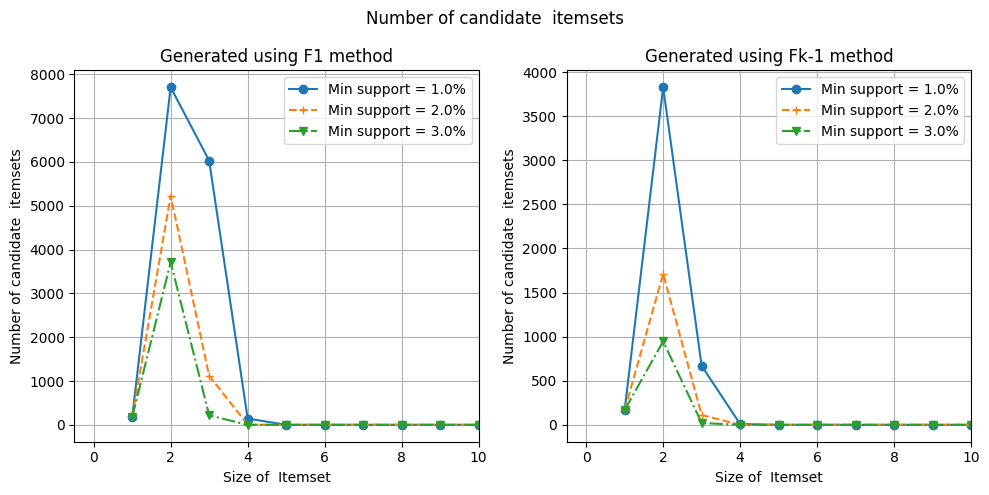

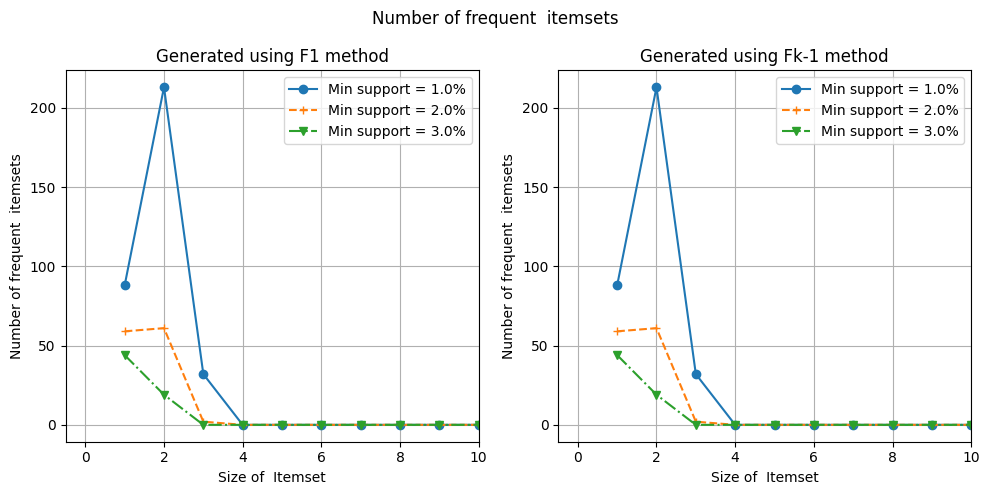

In [18]:
minsups = [0.01, 0.02, 0.03]
supDf = plots(minsups, itemsets=['candidate', 'frequent'], measure='support')

### Observations:
- From the above plots, we can see that number of candidate itemsets generated using Fk-1 x F1 method is large (almost double) compared to that generated using Fk-1 x Fk-1 method. Thus, the latter method reduces the overall time and space complexity of generating and storing the candidate itemsets and hence results in faster generation of all the valid candidate itemsets.

- Also, the number of generated candidate itemsets decreases with increase in the minimum support as an increasing minsup causes fewer itemsets to be above the minsup threshold and thus produces fewer itemsets in the subsequent iterations.

- The number of frequent itemsets generated is same for both the methods as the frequent itemset is the result of pruning the generated candidate itemsets using the Apriori principle and support pruning which doesn't depend on the choice of candidate itemset generation methods.

Number of candidate consequent itemsets


,minconf,F1,Fk-1
0,0.01,822,822
1,0.10,822,822
2,0.20,822,822


Number of frequent consequent itemsets


,minconf,F1,Fk-1
0,0.01,822,822
1,0.10,720,720
2,0.20,676,676


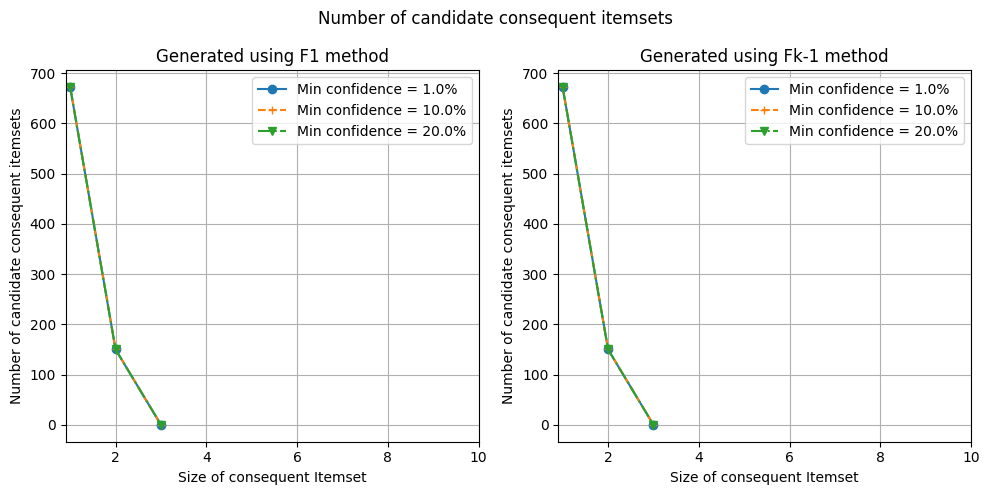

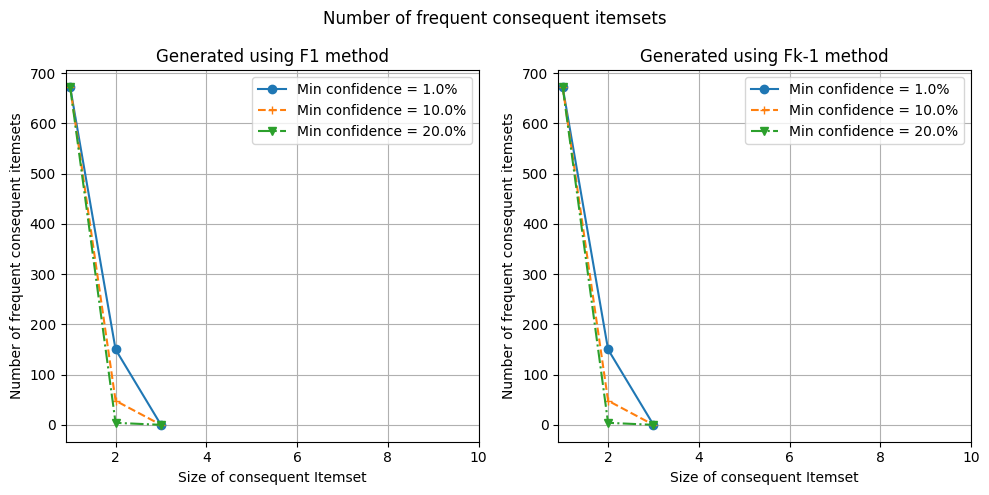

In [19]:
minconfs = [0.01, 0.1, 0.2]
confDf = plots(minconfs, itemsets=['candidate', 'frequent'], measure='confidence')

### Observations:
- From the above plots, we can see that number of candidate consequent itemsets generated using Fk-1 x F1 method and Fk-1 x Fk-1 method are same for minsup = 0.008. This can occur when all the candidate sets generated are valid in both the methods. (This can also be due to the fact that the items in each itemset are lexicographically sorted that prevents the unwanted itemsets from being generated in the first place and thus same candidate consequent itemsets are generated using both the methods.)

- Also, the number of frequent consequent itemsets decreases with increase in the minimum confidence as an increasing minconf causes fewer rules to satisfy the minconf threshold and thus generates fewer consequent itemsets in the subsequent iterations.

- The number of frequent itemsets generated is same for both the methods as the frequent itemset is the result of pruning the generated candidate consequent itemsets based on the confidence of the rules which doesn't depend on the choice of candidate itemset generation methods.